In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
%matplotlib inline
np.random.seed(2019)

In [2]:
def extract_temp(file_name,col_ind):
    data_aux = np.loadtxt(file_name, usecols=range(10))
    data = data_aux[:,col_ind]
    err_count = 0
    ind_errs = []
    for ind in range(data.shape[0]):
        if data[ind] > 100 or data[ind] < -100:
            err_count = err_count + 1
            ind_errs.append(ind)
            data[ind] = data[ind-1]  
    print( "File name: " + file_name)
    print( "Errors: " + str(err_count) + " Indices: " + str(ind_errs))
    return data

def create_data_matrix(str_path):
    file_name_list = listdir(str_path)
    file_name_list.sort()
    col_ind = 8 # 8 = last 5 minutes, 9 = average over the whole hour
    data_matrix = []
    ind = 0
    for file_name in file_name_list:
        if file_name[0] == '.':
            continue
        else:
            print("Station " + str(ind))
            ind = ind + 1
            data_aux = extract_temp(str_path + file_name,col_ind)
            if len(data_matrix) == 0:
                data_matrix = data_aux
            else:
                data_matrix = np.vstack((data_matrix,data_aux))
    return data_matrix.T

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

In [5]:
str_path = "./weather/"

load_files = False
if load_files:
    str_path_2015 = str_path + "hourly/2015/"
    data_matrix = create_data_matrix(str_path_2015)
    str_path_2016 = str_path + "hourly/2016/"
    data_matrix_2016 = create_data_matrix(str_path_2016)
else:
    data_matrix = np.load(str_path +"hourly_temperature_2015.npy")
    data_matrix_2016 = np.load(str_path +"hourly_temperature_2016.npy")

file_name_list = listdir(str_path + "hourly/2015/")
file_name_list.sort()

In [6]:
ind_response = 31 
print( "Response is " + str(file_name_list[ind_response]))
y_raw = data_matrix[:,ind_response]
y_2016 = data_matrix_2016[:,ind_response]
ind_X = np.hstack((np.arange(0,ind_response),np.arange(ind_response+1,data_matrix.shape[1])))
X_raw = data_matrix[:,ind_X]
X_2016 = data_matrix_2016[:,ind_X]
n_features = X_raw.shape[1]

n_test = int(1e3)
n_train_max = data_matrix.shape[0] - n_test
n_train_values = 40
n_train_list = np.around(np.logspace(np.log10(n_features),np.log10(n_train_max),n_train_values))
train_error_vec = []
test_error_vec = []
test_2016_vec = []
coeffs_matrix = np.zeros((n_features,len(n_train_list)))
col_norms_matrix = np.zeros((n_features,len(n_train_list)))
train_error_bs_vec = []
test_error_bs_vec = []

i_m = 0
for n_train in n_train_list:
    # split between training and test data
    aux_ind = np.random.permutation(range(data_matrix.shape[0]))
    ind_test = aux_ind[:n_test]
    X_test = X_raw[ind_test,:]
    y_test = y_raw[ind_test]
    ind_train = aux_ind[n_test:int(n_test+n_train)]
    X_train = X_raw[ind_train,:]
    y_train = y_raw[ind_train]
    
    # standardizing training and test data
    center_vec = X_train.mean(axis=0)
    X_train_centered = X_train - center_vec
    col_norms = np.linalg.norm(X_train_centered, axis=0) / np.sqrt(n_train)
    X_train_norm = np.true_divide(X_train_centered, col_norms)
    X_test_centered = X_test - center_vec
    X_test_norm = np.true_divide(X_test_centered, col_norms)
    X_2016_centered = X_2016 - center_vec
    X_2016_norm = np.true_divide(X_2016_centered, col_norms)
    y_train_center = y_train.mean()
    y_train_centered = y_train - y_train_center
    norm_y_train = np.linalg.norm(y_train_centered) / np.sqrt(n_train)
    y_train_norm = y_train_centered / norm_y_train
    coeffs_ls = np.linalg.lstsq(X_train_norm, y_train_norm)[0]
    y_train_est = norm_y_train * np.dot(X_train_norm, coeffs_ls) + y_train_center
    y_test_est = norm_y_train * np.dot(X_test_norm, coeffs_ls) + y_train_center
    y_2016_est = norm_y_train * np.dot(X_2016_norm, coeffs_ls) + y_train_center
    train_error = np.linalg.norm(y_train_est - y_train) / np.sqrt(len(y_train))
    test_error = np.linalg.norm(y_test_est - y_test) / np.sqrt(len(y_test))
    test_2016_error = np.linalg.norm(y_2016_est - y_2016) / np.sqrt(len(y_2016))
    train_error_vec.append(train_error)
    test_error_vec.append(test_error)
    test_2016_vec.append(test_2016_error)
    coeffs_matrix[:,i_m] = coeffs_ls
    col_norms_matrix[:,i_m] = col_norms
    i_m = i_m + 1
    
    # best station approach
    train_error_bs = 1
    for ind_feature in range(n_features):
        train_err_ind = np.linalg.norm(y_train - X_train[:,ind_feature])/np.sqrt(len(y_train))
        if ind_feature == 0 or train_err_ind < train_error_bs:
            train_error_bs = train_err_ind
            best = ind_feature
    test_error_bs = np.linalg.norm(y_test - X_test[:,best])/np.sqrt(len(y_test))
    test_2016_bs = np.linalg.norm(y_2016 - X_2016[:,best])/np.sqrt(len(y_2016))
    train_error_bs_vec.append(train_error_bs)
    test_error_bs_vec.append(test_error_bs)


Response is CRNH0203-2015-CO_Boulder_14_W.txt


/scratch/sl5924/dlenv/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


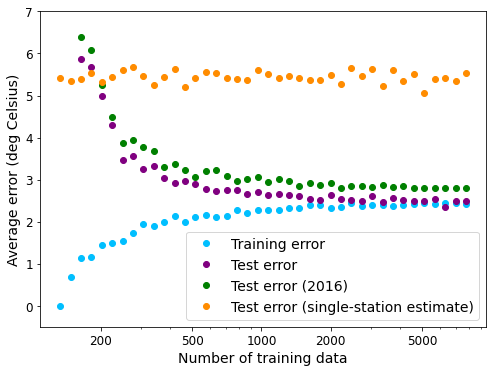

In [7]:
xticks=(np.array([200,500,1000,2000,5000]))
xtick_labels = ('200','500','1000','2000','5000')
plt.figure(figsize=(8,6))
plt.plot(n_train_list,train_error_vec,linestyle="None",marker='o', color='deepskyblue',label="Training error")
plt.plot(n_train_list,test_error_vec,linestyle="None",marker='o',color='purple',label="Test error")
plt.plot(n_train_list,test_2016_vec,linestyle="None",marker='o',color='green',label="Test error (2016)")
plt.plot(n_train_list,test_error_bs_vec,linestyle="None",marker='o', color='darkorange',label="Test error (single-station estimate)")
plt.ylim((-0.5,7))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Average error (deg Celsius)',fontsize=14)
plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
plt.legend(fontsize=14)
# plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(bottom=0.15)

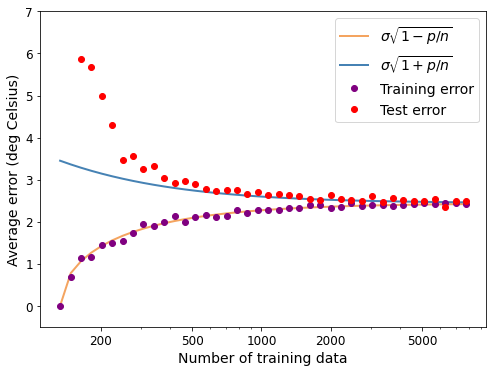

In [8]:
noise_constant = np.mean(train_error_vec[-5])
plt.figure(figsize=(8,6))
plt.plot(n_train_list,noise_constant* np.sqrt(1-n_features/n_train_list),color='sandybrown',label=r"$\sigma \sqrt{1-p/n}$", lw=2)
plt.plot(n_train_list,noise_constant* np.sqrt(1+n_features/(n_train_list)),color='steelblue',label=r"$\sigma \sqrt{1+p/n}$", lw=2)
plt.plot(n_train_list,train_error_vec,linestyle="None",marker='o', color='purple',label="Training error")
plt.plot(n_train_list,test_error_vec,linestyle="None",marker='o',color='red',label="Test error")
plt.ylim((-0.5,7))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Average error (deg Celsius)',fontsize=14)
plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
plt.legend(fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)

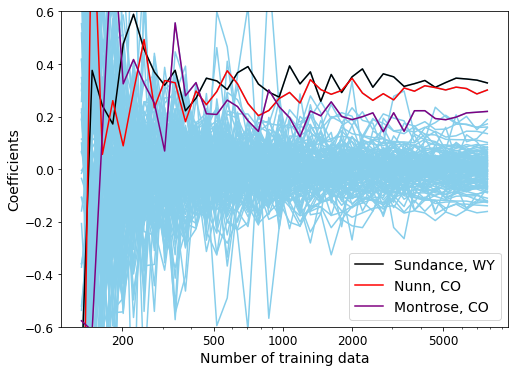

In [9]:
n_largest = 3
color_list = ['black','red','purple','brown','darkgreen']
sorted_coeffs = np.argsort(np.abs(coeffs_matrix[:,-1]))
largest_coeffs = sorted_coeffs[-1:(-n_largest-1):-1]
plt.figure(figsize=(8,6))
for ind in range(n_features):
    plt.plot(n_train_list,coeffs_matrix[ind,:],color='skyblue')
for ind in range(len(largest_coeffs)):
    ind_name = largest_coeffs[ind]
    if ind_name>=ind_response:
        ind_name = ind_name + 1
    aux_name = file_name_list[ind_name]
    plt.plot(n_train_list,coeffs_matrix[largest_coeffs[ind],:],color=color_list[ind],label=process_name(aux_name))
plt.ylim((-0.6,0.6))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Coefficients',fontsize=14)
plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc = 'lower right',fontsize=14)
plt.show()